In [11]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')

def apply_rotation(df: pd.DataFrame, rot_mat: np.ndarray, rot_angle: float) -> pd.DataFrame:
    df2 = df.copy()
    pts = df2[['center_x', 'center_y']].values.reshape(-1, 1, 2).astype(np.float32)
    pts2 = cv2.transform(pts, rot_mat.astype(np.float32))
    df2['center_x'] = pts2[:, 0, 0]
    df2['center_y'] = pts2[:, 0, 1]
    df2['phi'] = (df2['phi'] + rot_angle) % 360
    return df2

def rotate_block_eye_dataframes(block):
    """
    Rotate each eye‐data DataFrame in place using its own saved rotation matrix
    and angle. Does NOT write any files; only updates block.left_eye_data and
    block.right_eye_data.

    Requires the helper apply_rotation(df, rot_mat, rot_angle) to be in scope
    (which applies cv2.transform + phi += rot_angle).
    """
    # LEFT EYE
    R_L = np.array(block.left_rotation_matrix, dtype=np.float32)  # 2×3
    θ_L = float(block.left_rotation_angle)
    block.left_eye_data = apply_rotation(block.left_eye_data, R_L, θ_L)

    # RIGHT EYE
    R_R = np.array(block.right_rotation_matrix, dtype=np.float32)
    θ_R = float(block.right_rotation_angle)
    block.right_eye_data = apply_rotation(block.right_eye_data, R_R, θ_R)

    print("✅ Rotated left_eye_data and right_eye_data in memory.")
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [12]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_126','PV_62','PV_57']
block_lists = [[7,8,9,10,11,12],[24,26,38],[7,8,9,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_008, new OE version
could not find the sample rate in the xml file due to error, will look in the cont file of the first recording...
found the sample rate, it is 20000
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample 

In [13]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

#   Here, you can employ the tear-ducts rotation to horizontal
    rotate_block_eye_dataframes(block)



# NOTICE THE DIRECTION FLIP!@@@!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # for block in block_collection:
    #     block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
    #     block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')

    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
✅ Rotated left_eye_data and right_eye_data in memory.
running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
✅ Rotated left_eye_data and right_eye_data in memory.
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found

In [14]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


68it [00:00, 673.26it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 690.06it/s]
1180it [00:01, 676.22it/s]
69it [00:00, 690.00it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


366it [00:00, 669.49it/s]
399it [00:00, 668.46it/s]
69it [00:00, 683.34it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


359it [00:00, 669.73it/s]
434it [00:00, 686.71it/s]
65it [00:00, 650.00it/s]

PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


245it [00:00, 663.75it/s]
288it [00:00, 628.15it/s]
68it [00:00, 666.68it/s]

PV_126, block 011, on PV126_Trial115_eyeTracking_w7


1009it [00:01, 664.53it/s]
1006it [00:01, 695.56it/s]
115it [00:00, 732.08it/s]
0it [00:00, ?it/s]

PV_126, block 012, on PV126_Trial116_eyeTracking_h8


129it [00:00, 722.34it/s]
70it [00:00, 679.76it/s]

PV_62, block 024, on 2023-04-27_11-22-56


602it [00:00, 693.07it/s]
599it [00:00, 714.79it/s]
71it [00:00, 702.95it/s]

PV_62, block 026, on 2023-04-27_12-21-41


598it [00:00, 687.36it/s]
579it [00:00, 712.13it/s]
70it [00:00, 699.76it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1126it [00:01, 668.91it/s]
1123it [00:01, 578.05it/s]
72it [00:00, 712.88it/s]

PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


672it [00:00, 685.29it/s]
722it [00:01, 702.46it/s]
66it [00:00, 650.70it/s]

PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


638it [00:00, 653.75it/s]
599it [00:00, 734.09it/s]
76it [00:00, 759.80it/s]

PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


502it [00:00, 734.97it/s]
556it [00:00, 733.51it/s]
69it [00:00, 689.99it/s]

PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


589it [00:00, 677.01it/s]
474it [00:00, 646.64it/s]
73it [00:00, 729.97it/s]

PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


737it [00:01, 726.84it/s]
725it [00:01, 717.75it/s]


In [5]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return



# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    try:
        block_get_lizard_movement(block)
        label_saccade_movements(block)
    except Exception:
        print(f'problem with block {block.block_num}')


path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\Animal=PV_126,recNames=block_007\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\oe_files\PV126_Trial16_wake4_2024-07-18_13-24-41\Record Node 102\analysis\recNames=block_008,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\oe_files\PV126_Trial18_wake5_2024-07-18_14-39-15\Record Node 102\analysis\recNames=block_009,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_010\oe_files\PV126_Trial19_wake6_2024-07-18_15-24-57\Record Node 102\analysis\recNames=block_010,Animal=PV_126\lizM

In [6]:
# add annotations for a joint dataframe:
#
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [7]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [16]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1163it [00:00, 7092.88it/s]
341it [00:00, 3875.87it/s]
338it [00:00, 7511.38it/s]

342 1110
181 386



230it [00:00, 7187.70it/s]
0it [00:00, ?it/s]

204 414
129 273


961it [00:00, 7278.94it/s]
107it [00:00, 7132.94it/s]
577it [00:00, 7589.73it/s]

366 988
50 123



575it [00:00, 7563.09it/s]
0it [00:00, ?it/s]

199 568
190 547


1034it [00:00, 8580.62it/s]
669it [00:00, 7966.79it/s]
630it [00:00, 7325.67it/s]

599 1064
322 648



489it [00:00, 7758.71it/s]
0it [00:00, ?it/s]

209 563
271 510


581it [00:00, 7644.64it/s]
706it [00:00, 7129.22it/s]


144 463
280 694


In [17]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])

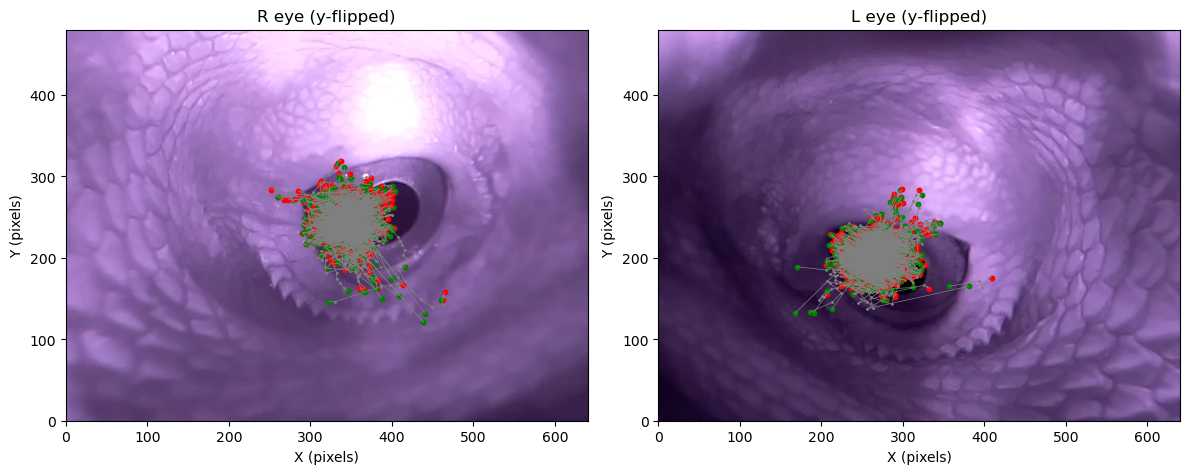

In [20]:
import cv2
import matplotlib.pyplot as plt

def plot_block_saccades(block, all_saccade_collection):
    """
    Creates a two-panel figure showing the y-flipped first frame for each eye
    with overlaid saccade trajectories:
      • Left panel: right eye (block.re_videos[0])
      • Right panel: left eye (block.le_videos[0])
    Saccades are filtered from all_saccade_collection by block number and animal,
    then for each eye we draw:
      – thin gray lines through all samples
      – small gray dots at intermediate points
      – a green dot at the first sample
      – a red dot at the last sample
    """
    # select only this block’s saccades
    block_sacs = all_saccade_collection[
        (all_saccade_collection['block'] == block.block_num) &
        (all_saccade_collection['animal'] == block.animal_call)
    ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # order panels: (axis, eye_label, video_path, eye_data_df)
    panels = [
        (axes[0], 'R', block.re_videos[0], block.right_eye_data),
        (axes[1], 'L', block.le_videos[0], block.left_eye_data),
    ]

    for ax, eye_label, video_path, eye_df in panels:
        # load first frame
        cap = cv2.VideoCapture(str(video_path))
        ret, frame = cap.read()
        cap.release()
        if not ret:
            raise RuntimeError(f"Could not read frame from {video_path}")

        # y-flip (vertical flip) and convert BGR→RGB
        frame_flipped = frame #cv2.flip(frame, 0)
        img = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # display with pixel axes
        ax.imshow(img, extent=[0, w, 0, h], origin='lower')
        ax.set_xlim(0, w)
        ax.set_ylim(0, h)
        ax.set_title(f"{eye_label} eye (y-flipped)")
        ax.set_xlabel("X (pixels)")
        ax.set_ylabel("Y (pixels)")

        # overlay each saccade for this eye
        eye_sacs = block_sacs[block_sacs['eye'] == eye_label]
        for _, sac in eye_sacs.iterrows():
            start_i = int(sac['saccade_start_ind'])
            end_i   = int(sac['saccade_end_ind'])
            segment = eye_df.iloc[start_i:end_i+1]
            xs = segment['center_x'].values
            ys = segment['center_y'].values

            # thin gray line
            ax.plot(xs, ys, color='gray', linewidth=0.5)
            # gray intermediate points
            if len(xs) > 2:
                ax.scatter(xs[1:-1], ys[1:-1], s=1, color='gray')
            # green start, red end
            ax.scatter(xs[0], ys[0], s=10, color='green')
            ax.scatter(xs[-1], ys[-1], s=10, color='red')

    plt.tight_layout()
    plt.show()

block = block_dict['PV_126_block_007']
plot_block_saccades(block,all_saccade_collection)

<ipython-input-22-63d0c28e3459>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


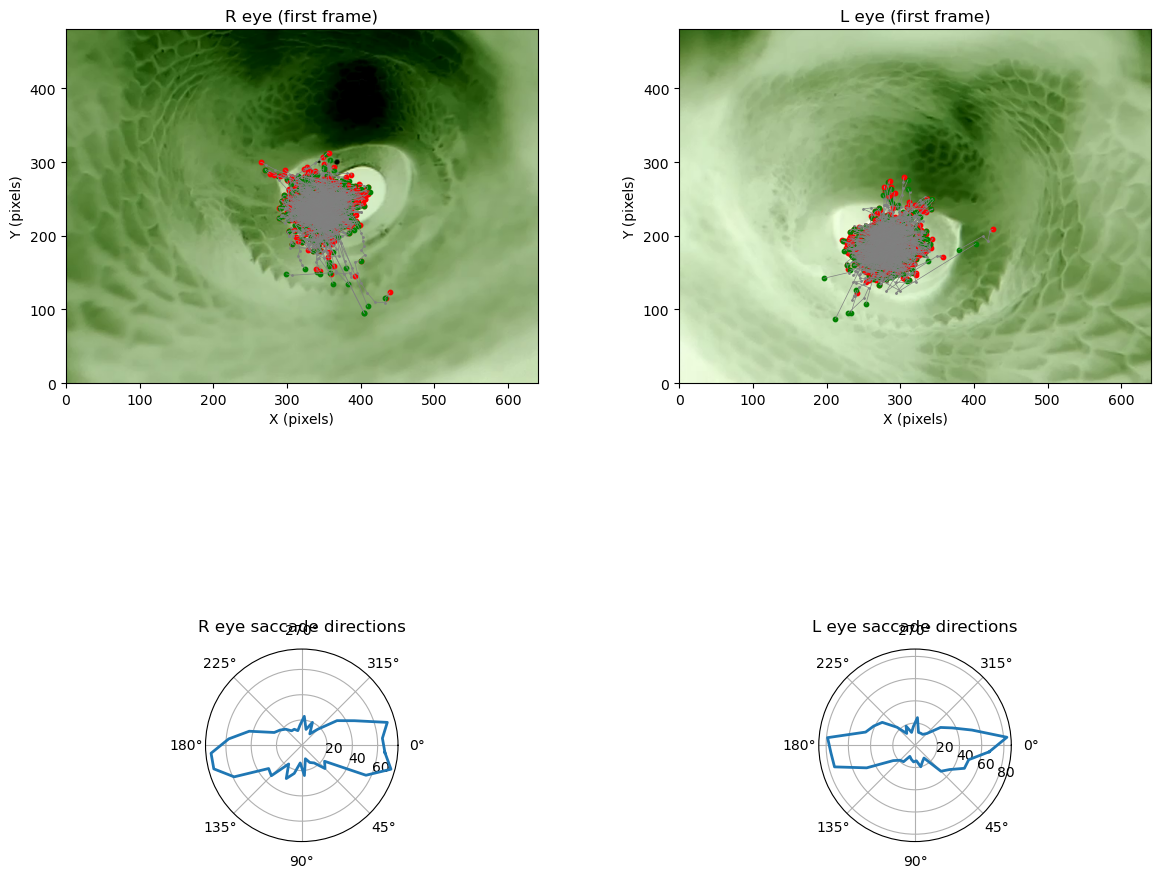

In [22]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_block_saccades_with_two_polar(block, all_saccade_collection, nbins=36):
    """
    Four-panel figure:
      • Top-left:  Right‐eye first frame + saccade trajectories
      • Top-right: Left‐eye first frame + saccade trajectories
      • Bottom-left:  Polar line‐histogram of right‐eye saccade directions
      • Bottom-right: Polar line‐histogram of left‐eye saccade directions

    Params
    ------
    block : BlockSync
        Must have .block_num, .animal_call,
        .re_videos, .le_videos, .right_eye_data, .left_eye_data.
    all_saccade_collection : pd.DataFrame
        Must contain columns ['block','animal','eye','angle','saccade_start_ind','saccade_end_ind'].
    nbins : int
        Number of angular bins for the polar histograms.
    """
    # 1) Filter to this block & drop NaN angles
    mask = (
        (all_saccade_collection['block']  == block.block_num) &
        (all_saccade_collection['animal'] == block.animal_call)
    )
    block_sacs = all_saccade_collection.loc[mask].dropna(subset=['angle'])

    # 2) Separate angles by eye, convert to radians
    right_angles_deg = block_sacs.loc[block_sacs['eye']=='R','angle']
    left_angles_deg  = block_sacs.loc[block_sacs['eye']=='L','angle']
    right_angles_rad = (right_angles_deg * (math.pi/180.0)).to_numpy()
    left_angles_rad  = (left_angles_deg  * (math.pi/180.0)).to_numpy()

    # 3) Create 2x2 grid: top row images, bottom row polars
    fig = plt.figure(figsize=(14, 12))
    gs  = fig.add_gridspec(2, 2,
                           height_ratios=[3, 1],
                           width_ratios=[1, 1],
                           hspace=0.4, wspace=0.3)

    ax_img_r = fig.add_subplot(gs[0,0])
    ax_img_l = fig.add_subplot(gs[0,1])
    ax_pol_r = fig.add_subplot(gs[1,0], projection='polar')
    ax_pol_l = fig.add_subplot(gs[1,1], projection='polar')

    def draw_eye_panel(ax, eye_label, video_path, eye_df):
        # load first frame
        cap = cv2.VideoCapture(str(video_path))
        ret, frame = cap.read()
        cap.release()
        if not ret:
            raise RuntimeError(f"Could not read frame from {video_path}")

        # correct negative appearance
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = 255 - img

        h, w, _ = img.shape
        ax.imshow(img, extent=[0, w, 0, h], origin='lower', cmap='gray', vmin=0, vmax=255)
        ax.set_xlim(0, w)
        ax.set_ylim(0, h)
        ax.set_title(f"{eye_label} eye (first frame)")
        ax.set_xlabel("X (pixels)")
        ax.set_ylabel("Y (pixels)")

        # overlay saccades
        sacs = block_sacs[block_sacs['eye'] == eye_label]
        for _, sac in sacs.iterrows():
            si, ei = int(sac['saccade_start_ind']), int(sac['saccade_end_ind'])
            seg = eye_df.iloc[si:ei+1]
            xs, ys = seg['center_x'].values, seg['center_y'].values

            ax.plot(xs, ys, color='gray', linewidth=0.5)
            if len(xs) > 2:
                ax.scatter(xs[1:-1], ys[1:-1], s=1, color='gray')
            ax.scatter(xs[0], ys[0], s=10, color='green')
            ax.scatter(xs[-1], ys[-1], s=10, color='red')

    # Draw the two image panels
    draw_eye_panel(ax_img_r, 'R', block.re_videos[0], block.right_eye_data)
    draw_eye_panel(ax_img_l, 'L', block.le_videos[0], block.left_eye_data)

    # 4) Polar line‐histograms
    def draw_polar_line(ax, angles_rad, title):
        # compute histogram
        counts, bins = np.histogram(angles_rad, bins=nbins, range=(0, 2*math.pi))
        centers = (bins[:-1] + bins[1:]) / 2.0
        # ensure closed loop
        centers = np.concatenate((centers, [centers[0]]))
        counts  = np.concatenate((counts,  [counts[0]]))

        ax.plot(centers, counts, linewidth=2)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
        ax.set_title(title)

    draw_polar_line(ax_pol_r, right_angles_rad, "R eye saccade directions")
    draw_polar_line(ax_pol_l, left_angles_rad,  "L eye saccade directions")

    plt.tight_layout()
    plt.show()

block = block_dict['PV_126_block_007']
plot_block_saccades_with_two_polar(block, all_saccade_collection, nbins=36)

<ipython-input-17-1e138c4d706c>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


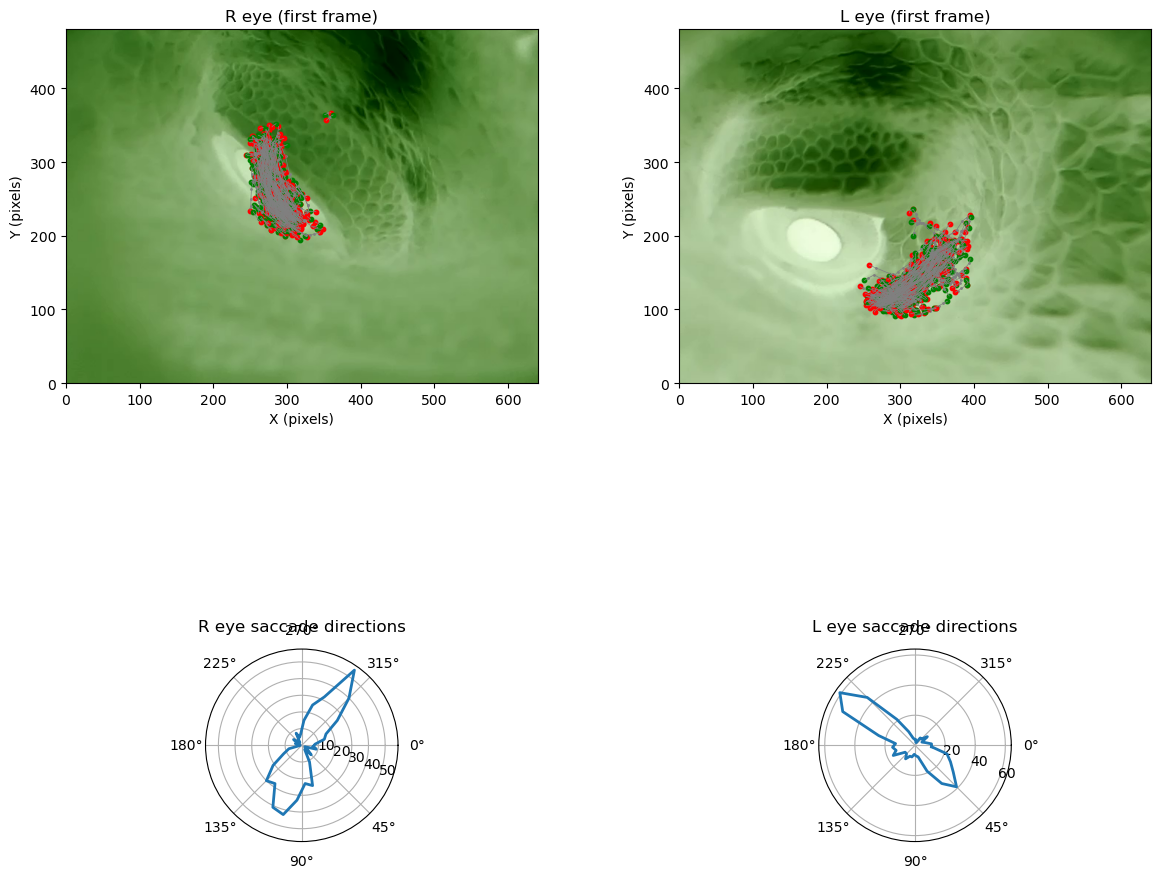

In [18]:
block=block_dict['PV_62_block_023']
plot_block_saccades_with_two_polar(block, all_saccade_collection, nbins=36)

<ipython-input-17-1e138c4d706c>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


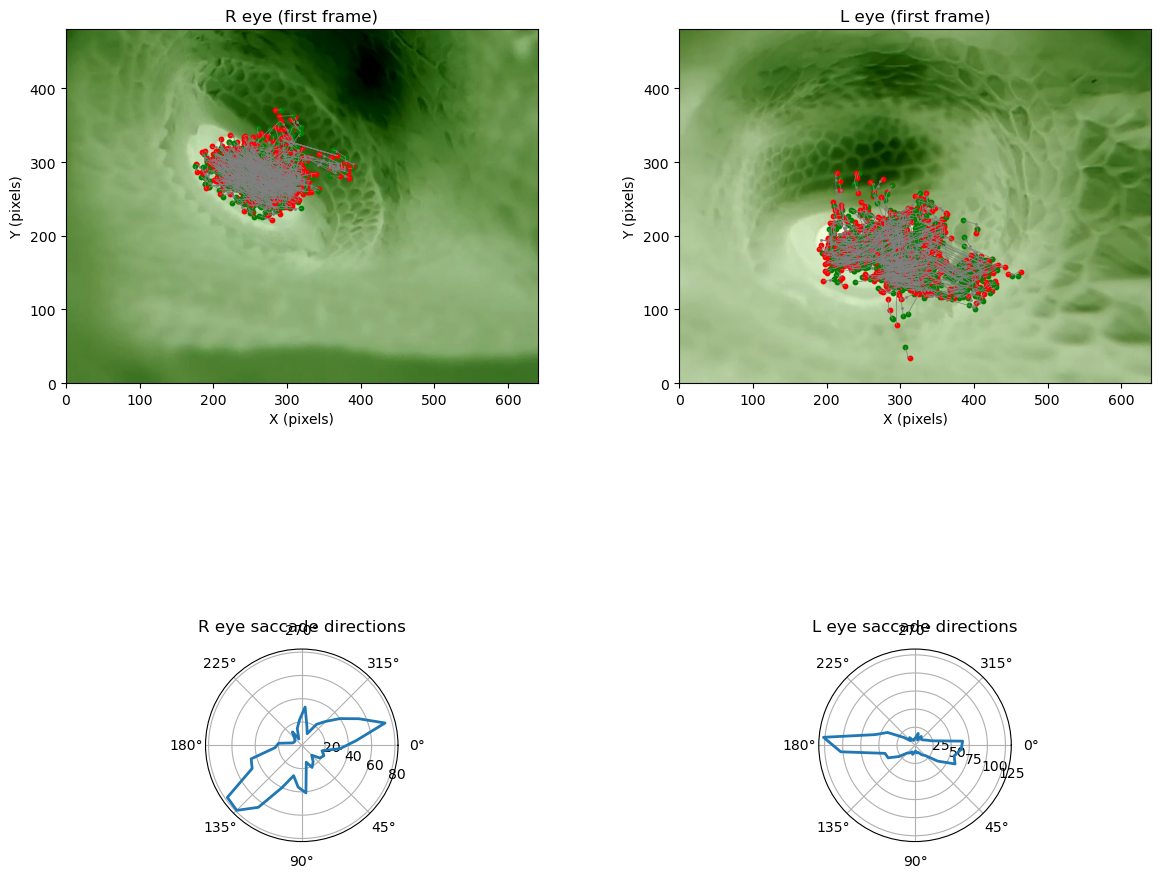

In [20]:
block=block_dict['PV_62_block_038']

plot_block_saccades_with_two_polar(block, all_saccade_collection, nbins=36)

<ipython-input-17-1e138c4d706c>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


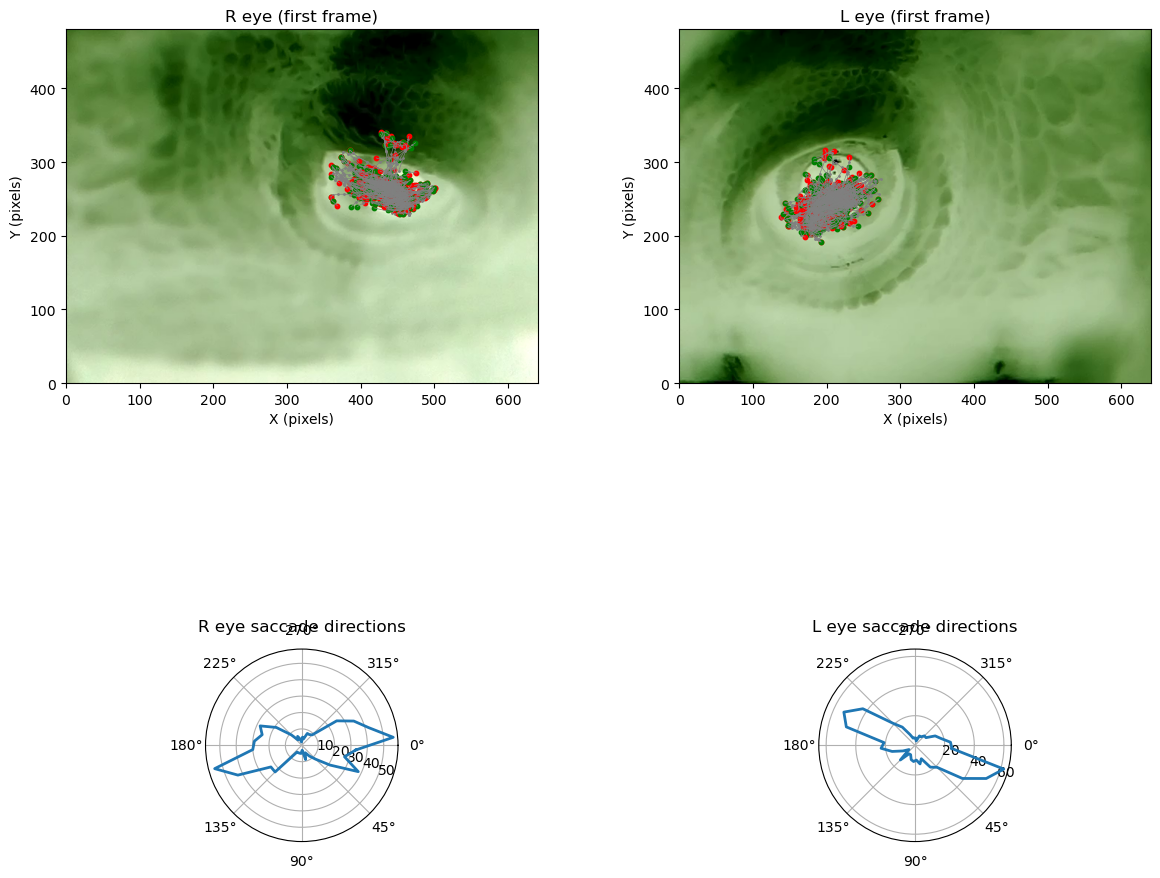

In [19]:
block=block_dict['PV_57_block_007']
plot_block_saccades_with_two_polar(block, all_saccade_collection, nbins=36)

In [11]:
block_dict.keys()

dict_keys(['PV_126_block_007', 'PV_126_block_008', 'PV_126_block_009', 'PV_62_block_023', 'PV_62_block_024', 'PV_62_block_038', 'PV_57_block_007', 'PV_57_block_008', 'PV_57_block_009', 'PV_57_block_012'])

In [25]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram(saccade_collection, figure_size=(4,3),export_path=None):
    # Extract saccade angles for both eyes
    saccade_angles_r = saccade_collection.query('eye == "R"')['angle']
    saccade_angles_l = saccade_collection.query('eye == "L"')['angle']

    font_size = 10
    num_bins = 36

    # Compute histograms and bin centers
    hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
    bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2

    hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
    bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2

    # Calculate maximum radial value for consistent scaling
    max_count = max(hist_r.max(), hist_l.max())

    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))

    # Iterate over eyes and plot histograms
    for ax, saccade_angles, bin_centers, hist, title in zip(
            axs,
            [saccade_angles_r, saccade_angles_l],
            [bin_centers_r, bin_centers_l],
            [hist_r, hist_l],
            [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye - {len(saccade_angles_l)}']
        ):

        # Plot histogram bars
        ax.bar(
            np.deg2rad(list(bin_centers.astype(int))),
            hist,
            width=np.deg2rad(360 / num_bins),
            align='center',
            color='black',
            edgecolor='black'
        )

        # Set maximum radial value for comparison
        ax.set_ylim(0, max_count)

        # Add radial gridlines
        radial_steps = np.linspace(0, max_count, 5)[1:]
        for step in radial_steps:
            ax.plot(np.linspace(0, 2*np.pi, 100), [step]*100, linestyle='dotted', color='gray', lw=0.7)
            ax.text(
                np.pi/2, step, f'{int(step)}',
                color='gray', fontsize=font_size-2,
                ha='center', va='bottom'
            )

        ax.grid(False)
        ax.tick_params(axis='both', labelsize=font_size-2)
        ax.set_yticks([])
        #ax.set_title(title, y=1.1, fontsize=font_size)

    plt.tight_layout()

    # Save the figure and pickle file if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


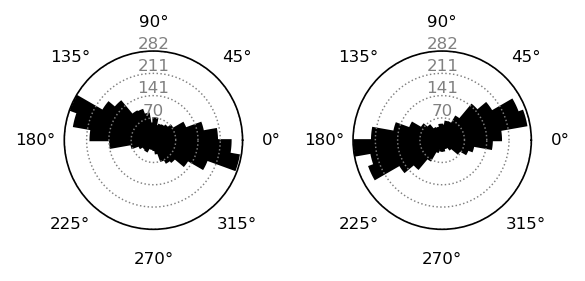

In [38]:
# before correction
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar')
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

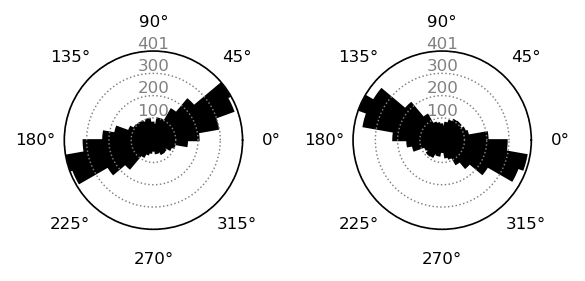

In [41]:
# after correction, before rotation
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar')
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

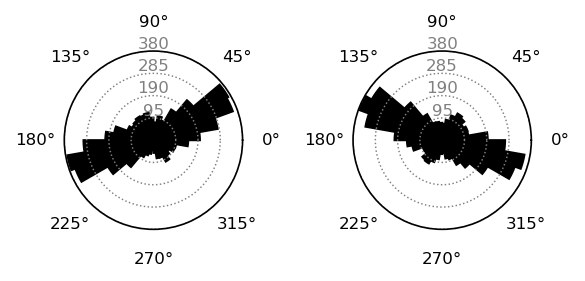

In [26]:
# after correction, and rotation
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar')
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

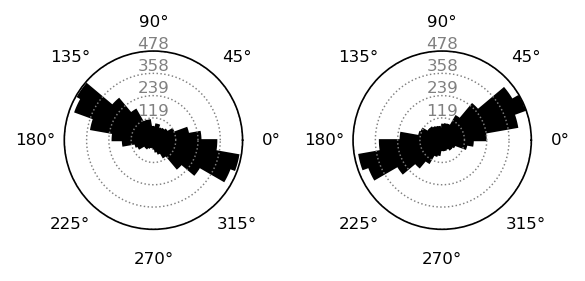

In [25]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar')
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

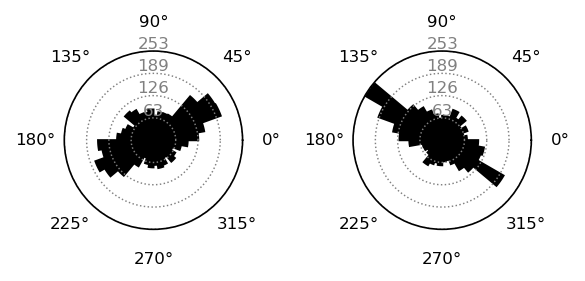

In [31]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar')
create_saccade_polar_histogram(non_synced_saccade_collection, (4,3),export_path=None)

In [56]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['angle']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list(np.array((bin_edges_r[:-1] + bin_edges_r[1:]) / 2).astype(int))
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} ({len(saccade_angles_r)} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['angle']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list(np.array((bin_edges_l[:-1] + bin_edges_l[1:]) / 2).astype(int))
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal} ({len(saccade_angles_l)} saccades)',
            color=color
        )

    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)
        #ax.set_title(f'{title} Saccades', va='bottom')
        ax.grid(False)

        ax.set_yticks([])

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


In [9]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    """
    For each animal in `saccade_collection`, compute a 36‐bin histogram of angles (0–360°), then plot
    right‐eye and left‐eye polar histograms side by side.  We “close” the circle by appending the first
    bin again at 360° (i.e. +2π), so that the final bin is visible.
    """

    # 1. Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # 2. Set up two polar subplots (one for R, one for L)
    fig, axs = plt.subplots(
        1, 2,
        figsize=figure_size,
        dpi=150,
        subplot_kw=dict(projection='polar')
    )
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))

    for color, animal in zip(colors, animals):
        # Filter all saccades belonging to this animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # --- Right eye histogram ---
        saccade_angles_r = animal_saccades.query('eye == "R"')['angle']
        hist_r, bin_edges_r = np.histogram(
            saccade_angles_r,
            bins=num_bins,
            range=(0, 360),
            density=True
        )
        # Compute bin centers in degrees (as a numpy array of floats)
        bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2.0  # shape=(36,)

        # Convert to radians manually (avoid np.deg2rad)
        centers_rad_r = bin_centers_r * (np.pi / 180.0)
        # Append one extra point at +2π to “close” the circle
        centers_rad_r = np.concatenate([centers_rad_r, [centers_rad_r[0] + 2 * np.pi]])
        hist_r_closed = np.concatenate([hist_r, [hist_r[0]]])

        axs[0].plot(
            centers_rad_r,
            hist_r_closed,
            label=f'{animal} ({len(saccade_angles_r)} saccades)',
            color=color
        )

        # --- Left eye histogram ---
        saccade_angles_l = animal_saccades.query('eye == "L"')['angle']
        hist_l, bin_edges_l = np.histogram(
            saccade_angles_l,
            bins=num_bins,
            range=(0, 360),
            density=True
        )
        bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2.0

        centers_rad_l = bin_centers_l * (np.pi / 180.0)
        centers_rad_l = np.concatenate([centers_rad_l, [centers_rad_l[0] + 2 * np.pi]])
        hist_l_closed = np.concatenate([hist_l, [hist_l[0]]])

        axs[1].plot(
            centers_rad_l,
            hist_l_closed,
            label=f'{animal} ({len(saccade_angles_l)} saccades)',
            color=color
        )

    # 3. Formatting: remove radial ticks, add legends, remove grid lines
    for ax in axs:
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)
        ax.grid(False)
        ax.set_yticks([])

    plt.tight_layout()

    # 4. Optional: save to PDF + pickle if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Pickle (just re‐dump the original DataFrame/collection)
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


In [5]:
# Replace this with the actual path to your .pkl file
pkl_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_01_04_16_02_MultiAnimal_Saccade_Histogram\2025_01_04_16_02_saccade_angles_data.pkl"

# Option 1: Using pandas
all_xy_saccades_old = pd.read_pickle(pkl_path)

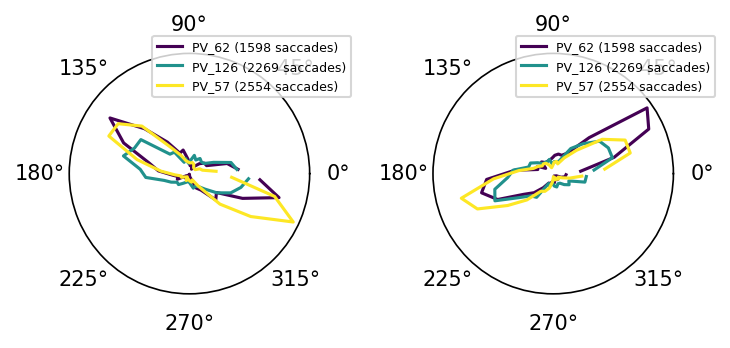

In [7]:
# before verification, with rotation, no x-flip
create_saccade_polar_histogram_multianimal(all_xy_saccades_old,(5,4))

In [10]:
# Before verification, with rotation, x-flipped
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=export_path)

NameError: name 'synced_saccade_collection' is not defined

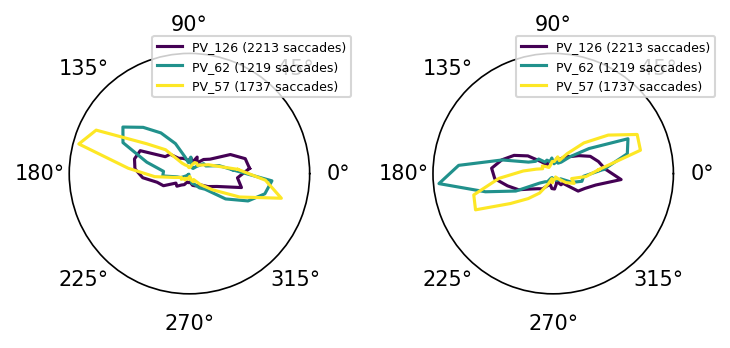

In [19]:
# After verification, raw (no rotation of eye data according to tear ducts)
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)


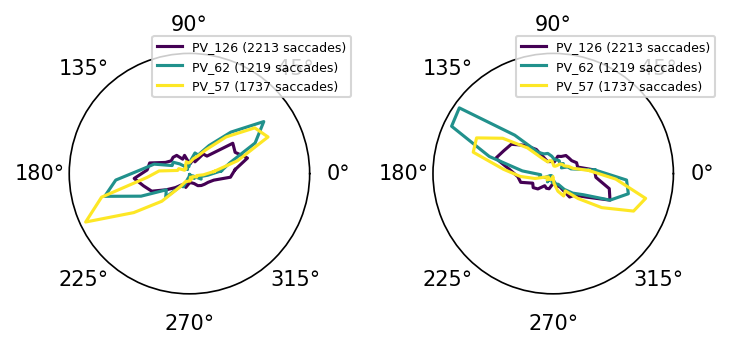

In [23]:
# After verification, and tear ducts correction:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

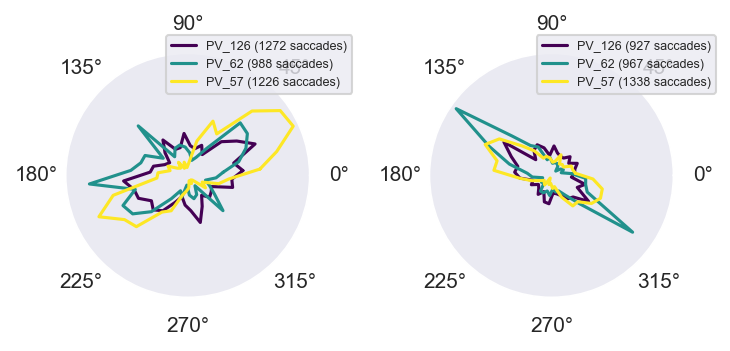

In [24]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection, (5,4),export_path=None)

In [ ]:
#older_version
saccade_angles_r = synced_saccade_collection.query('eye == "R"')['angle']
saccade_angles_l = synced_saccade_collection.query('eye == "L"')['angle']
font_size = 10
num_bins = 36
hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(3, 4), dpi=150, subplot_kw=dict(projection='polar'))
#fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
#             f'Blocks: {[b.block_num for b in block_collection]} \n'
#            f'Overall {len(non_synced_saccade_collection)} non-synced saccades', fontsize=font_size-2, y=1)
#fig.patch.set_facecolor('white')
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                  [bin_centers_r, bin_centers_l],
                                                  [f'Right Eye - {len(saccade_angles_r)}',
                                                   f'Left Eye - {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))

    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center',
           color='black', edgecolor='black')
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    #ax.set_title(title,y=1.1)
    #ax.set_facecolor('white')
# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\PV_126\{t}_Non_synced_saccade_angles_histogram.pdf', format='pdf')
plt.show()